In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data/dfmerged.csv')
df = df.drop(['Unnamed: 0', 'eval_set', 'aisle', 'department', 'product_name'], axis = 1)
df.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
0,2539329,1,1,2,8,NaN,196,1,0,77,7
1,2398795,1,2,3,7,15.0,196,1,1,77,7
2,473747,1,3,3,12,21.0,196,1,1,77,7
3,2254736,1,4,4,7,29.0,196,1,1,77,7
4,431534,1,5,4,15,28.0,196,1,1,77,7


## 1.1 Create table of predictor variables 

Import the user data frame created with average order size, average reorder ratio, total products ordered, total products reordered, and total orders 

In [3]:


user = pd.read_csv('data/user.csv')
user.head()

,user_id,reordered,total_orders,total_products,average_order_size,average_reorder
0,1,51,11,70,6.36,0.73
1,2,105,15,226,15.07,0.46
2,3,55,12,88,7.33,0.62
3,4,1,5,18,3.60,0.06
4,5,18,5,46,9.20,0.39


Import product data frame with percent reorder ratio of each product.

In [4]:
product = pd.read_csv('data/prodpred.csv')
product = product.drop(['Unnamed: 0', 'product_name', 'aisle_id','department_id', 'department'], axis=1).sort_values(by='product_id').reset_index()
product = product.drop(['index'], axis=1)
product.head()

,product_id,p_total_reorders,p_total_purchases,percent_reorder
0,1,1185,1928,0.614627
1,2,13,94,0.138298
2,3,209,283,0.738516
3,4,161,351,0.458689
4,5,10,16,0.625000


The goal here is to get the ratio of reorders of a product by a customer after the first time they bought the product. So essentially, we will result with the following equation. 

reorder ratio of product by customer = (total bought) / (total number of chances to buy product after first purchase)

We do so by:

1. getting the total number of times (total_bought)
2. getting the first order number the customer purchased that item (first_order_num)
3. the total number of orders the customer made (total_orders)
4. calculating the number of chances after first purchase(up_reorder) = total # purchases - first order number + 1
5. calculating ratio(up_reorder_ratio) = total bought /# chances after first purchase 

In [5]:
#1. getting the total number of times 
user_prod = df.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('total_bought').reset_index()
user_prod.head()

,user_id,product_id,total_bought
0,1,196,11
1,1,10258,10
2,1,10326,1
3,1,12427,10
4,1,13032,4


In [6]:
#2. getting the first order number the customer purchased that item (first_order_num)
first_order_num = df.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_num').reset_index()
first_order_num.head()

,user_id,product_id,first_order_num
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


In [7]:
#3. the total number of orders the customer made (total_orders)
total_orders = user[['user_id','total_orders']]
first_order_num = first_order_num.merge(total_orders, on = 'user_id', how = 'left')
first_order_num.head()

,user_id,product_id,first_order_num,total_orders
0,1,196,1,11
1,1,10258,2,11
2,1,10326,5,11
3,1,12427,1,11
4,1,13032,2,11


In [8]:
#merging the two data frames 
first_order_num = first_order_num.merge(user_prod, on = ['user_id', 'product_id'], how = 'left')
first_order_num.head()

,user_id,product_id,first_order_num,total_orders,total_bought
0,1,196,1,11,11
1,1,10258,2,11,10
2,1,10326,5,11,1
3,1,12427,1,11,10
4,1,13032,2,11,4


In [9]:
#4. calculating the number of chances after first purchase(up_reorders) = total # purchases - first order number + 1
#5. calculating ratio(up_reorder_ratio) = total bought /# chances after first purchase 

first_order_num['up_reorders'] = first_order_num.total_orders - first_order_num.first_order_num + 1
first_order_num['up_reorder_ratio'] = first_order_num.total_bought / first_order_num.up_reorders
first_order_num.head()

,user_id,product_id,first_order_num,total_orders,total_bought,up_reorders,up_reorder_ratio
0,1,196,1,11,11,11,1.000000
1,1,10258,2,11,10,10,1.000000
2,1,10326,5,11,1,7,0.142857
3,1,12427,1,11,10,11,0.909091
4,1,13032,2,11,4,10,0.400000


Then we will add the average days between order for each product/user ID combo to see if this and the days since last order will serve as good predictor variables of the reorder. 

In [10]:
avg_days = df.groupby(['user_id', 'product_id'])['days_since_prior_order'].mean().to_frame('avg_days_btw_order').reset_index()
avg_days.head()

,user_id,product_id,avg_days_btw_order
0,1,196,19.000000
1,1,10258,19.000000
2,1,10326,28.000000
3,1,12427,19.555556
4,1,13032,19.750000


In [11]:
# merge the two data frames from above
user_prod = first_order_num.merge(avg_days, on =['user_id', 'product_id'], how ='left')
user_prod.head()

,user_id,product_id,first_order_num,total_orders,total_bought,up_reorders,up_reorder_ratio,avg_days_btw_order
0,1,196,1,11,11,11,1.000000,19.000000
1,1,10258,2,11,10,10,1.000000,19.000000
2,1,10326,5,11,1,7,0.142857,28.000000
3,1,12427,1,11,10,11,0.909091,19.555556
4,1,13032,2,11,4,10,0.400000,19.750000


In [12]:
df.columns

Index(['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'product_id', 'add_to_cart_order',
       'reordered', 'aisle_id', 'department_id'],
      dtype='object')

Now we will start to build our data frame with our predictor variables and target variable using just the last orders from each customer. This is because we are just wanting to predict what will be in the last order of each customer. We've created predictor variables for each user/product combo based on all the prior purchasing history. This included with the last order contents we will try to formulate a prediction.

In [13]:
df = df[[ 'user_id','product_id', 'order_number','order_id','reordered', 'days_since_prior_order']]
df = df.merge(user_prod[['user_id','product_id','total_orders']], on = ['user_id','product_id'], how = 'left')
df.head()

,user_id,product_id,order_number,order_id,reordered,days_since_prior_order,total_orders
0,1,196,1,2539329,0,NaN,11
1,1,196,2,2398795,1,15.0,11
2,1,196,3,473747,1,21.0,11
3,1,196,4,2254736,1,29.0,11
4,1,196,5,431534,1,28.0,11


In [14]:
df = df.loc[df['order_number']== df['total_orders']].sort_values(by=['user_id', 'product_id']).reset_index()
df.drop(['index'], axis=1, inplace=True)
df.head()

,user_id,product_id,order_number,order_id,reordered,days_since_prior_order,total_orders
0,1,196,11,1187899,1,14.0,11
1,1,10258,11,1187899,1,14.0,11
2,1,13032,11,1187899,1,14.0,11
3,1,25133,11,1187899,1,14.0,11
4,1,26088,11,1187899,1,14.0,11


Now it is time to join our X variables with the set of orders we are trying to predict which items will be reordered or not. 

In [15]:
user_prod.columns

Index(['user_id', 'product_id', 'first_order_num', 'total_orders',
       'total_bought', 'up_reorders', 'up_reorder_ratio',
       'avg_days_btw_order'],
      dtype='object')

In [16]:
# creating our user/product datafram to include the reorder ratio of each individual product across all users 
up_df = user_prod[['user_id', 'product_id','total_bought','up_reorder_ratio', 'avg_days_btw_order']]
p_df = product[['product_id', 'percent_reorder']]
up_df = up_df.merge(p_df, on ='product_id', how ='left')
up_df.head()

,user_id,product_id,total_bought,up_reorder_ratio,avg_days_btw_order,percent_reorder
0,1,196,11,1.000000,19.000000,0.777843
1,1,10258,10,1.000000,19.000000,0.715610
2,1,10326,1,0.142857,28.000000,0.653439
3,1,12427,10,0.909091,19.555556,0.740182
4,1,13032,4,0.400000,19.750000,0.661117


In [17]:
up_df.shape

(13863746, 6)

In [18]:
df.shape

(2165417, 7)

In [19]:
#merging the user/product dataframe to the df of just the last orders. 
#We will do a left merge to drop all the user/product info for products 
#on orders previous to the very last order of each customer

df = df.merge(up_df, on = ['user_id','product_id'], how = 'left')
df.drop(['product_id', 'order_number', 'order_id'], axis =1, inplace=True)

df.head()

,user_id,reordered,days_since_prior_order,total_orders,total_bought,up_reorder_ratio,avg_days_btw_order,percent_reorder
0,1,1,14.0,11,11,1.000000,19.000000,0.777843
1,1,1,14.0,11,10,1.000000,19.000000,0.715610
2,1,1,14.0,11,4,0.400000,19.750000,0.661117
3,1,1,14.0,11,9,1.000000,19.444444,0.740364
4,1,1,14.0,11,3,0.272727,14.500000,0.540429


In [20]:
df.to_csv('data/predictor_df.csv', index= False)

In [21]:
no_reorders = df.loc[df['reordered']== 0]
no_reorders = no_reorders.loc[no_reorders['up_reorder_ratio']== 1.0]
no_reorders.shape

(879115, 8)

In [22]:
a = first_order_num.loc[first_order_num['up_reorders']== first_order_num['total_bought']]
a.head()

,user_id,product_id,first_order_num,total_orders,total_bought,up_reorders,up_reorder_ratio
0,1,196,1,11,11,11,1.0
1,1,10258,2,11,10,10,1.0
8,1,25133,3,11,9,9,1.0
11,1,27845,11,11,1,1,1.0
14,1,38928,10,11,2,2,1.0


Now we will split the user id's into a train and test set since we want to keep all the orders from one user in either the train or test set but not in both. 

In [23]:
user_id = df.user_id.unique()

In [24]:
user_train, user_test = train_test_split(user_id, test_size = .20, random_state = 123)

In [25]:
user_train.sort()
user_train

array([     1,      2,      3, ..., 206206, 206208, 206209])

In [26]:
user_test.sort()
user_test

array([    15,     22,     23, ..., 206199, 206204, 206207])

Here we are creating the X_test, y_test sets with the predictor variables for X and the target variables for Y

In [27]:
X_test = df[df['user_id'].isin(user_test)]
y_test = X_test['reordered']
X_test = X_test.drop(['user_id', 'reordered'], axis=1).reset_index()
X_test = X_test.drop(['index'], axis=1)
X_test.head()

,days_since_prior_order,total_orders,total_bought,up_reorder_ratio,avg_days_btw_order,percent_reorder
0,14.0,22,5,0.625000,8.600000,0.777843
1,14.0,22,8,0.363636,11.428571,0.701945
2,30.0,15,3,0.272727,19.666667,0.640876
3,30.0,15,2,0.142857,30.000000,0.665063
4,30.0,15,6,0.400000,17.000000,0.831045


We do the same for X_train and y_train

In [28]:
X_train = df[df['user_id'].isin(user_train)]
y_train = X_train['reordered']
X_train = X_train.drop(['user_id', 'reordered'], axis=1).reset_index()
X_train = X_train.drop(['index'], axis=1)
X_train.head()

,days_since_prior_order,total_orders,total_bought,up_reorder_ratio,avg_days_btw_order,percent_reorder
0,14.0,11,11,1.000000,19.000000,0.777843
1,14.0,11,10,1.000000,19.000000,0.715610
2,14.0,11,4,0.400000,19.750000,0.661117
3,14.0,11,9,1.000000,19.444444,0.740364
4,14.0,11,3,0.272727,14.500000,0.540429


In [29]:
y_train.value_counts()

1    1030078
0     704331
Name: reordered, dtype: int64

In [30]:
y_test.value_counts()

1    256224
0    174784
Name: reordered, dtype: int64

In [31]:
y_train.shape

(1734409,)

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt 




Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


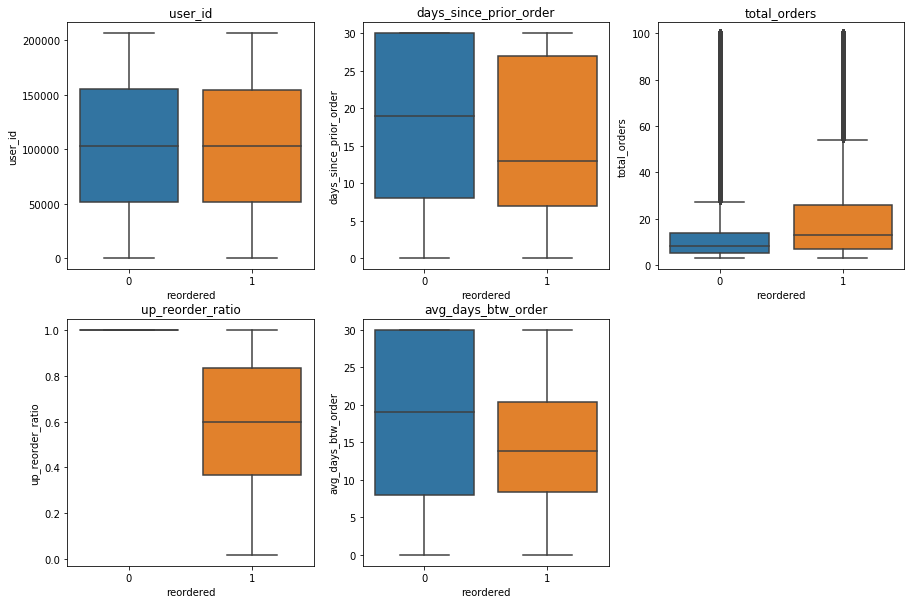

In [33]:
X_col =['user_id', 'days_since_prior_order', 'total_orders',
        'up_reorder_ratio', 'avg_days_btw_order',
       'percent_reorder']

fig = plt.figure(figsize= (15,10))
for col, num in zip (X_col, range( 1,len(X_col))):
    plt.subplot(2,3,num)
    sns.boxplot(y = col , x ='reordered', data = df)
    plt.title(col)
fig.savefig('featureboxplots.png')            
plt.show()

The distribution of 'total_bought' is creating errors in our model and therefore we are dropping it. 


In [34]:
X_train = X_train.drop(['total_bought'], axis=1)
X_test = X_test.drop(['total_bought'], axis=1)

In [35]:
X_train.to_csv('data/X_train.csv', index=False)
y_train.to_csv('data/y_train.csv', index=False)
X_test.to_csv('data/X_test.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)